In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 48845770.64it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

In [5]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [6]:
# conv module with or without batchnorm based on bn_flag
class ConvModule(nn.Module):
    
    def __init__(self , bn_flag , in_channels , out_channels , kernel_size , stride , padding):
        super(ConvModule , self).__init__()
        self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
        self.bn_flag = bn_flag
        if bn_flag:
            self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self , input):
        output = self.conv(input)
        if self.bn_flag:
            output = self.bn(output)
        output = self.relu(output)
        return output



class InceptionModule(nn.Module):
    
    def __init__(self , bn_flag , in_channels , Ch1 , Ch3):
        super(InceptionModule , self).__init__()
        self.branch1 = ConvModule(bn_flag , in_channels , Ch1 , kernel_size = 1 , stride = 1 , padding = 0)
        self.branch2 = ConvModule(bn_flag , in_channels , Ch3 , kernel_size = 3 , stride = 1 , padding = 1)

    def forward(self , input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        return torch.cat([branch1 , branch2] , 1)



class DownSampleModule(nn.Module):

    def __init__(self , bn_flag , in_channels , Ch3):
        super(DownSampleModule , self).__init__()
        self.branch1 = ConvModule(bn_flag , in_channels , Ch3 , kernel_size = 3 , stride = 2 , padding = 0)
        self.branch2 = nn.MaxPool2d(3 , stride = 2)
    
    def forward(self , input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        return torch.cat([branch1 , branch2] , 1)



class InceptionNet(nn.Module):
    
    def __init__(self , bn_flag , classes = 10):
        super(InceptionNet , self).__init__()
        self.conv1 = ConvModule(bn_flag , in_channels = 3 , out_channels = 96 , kernel_size = 3 , stride = 1 , padding = 0)
        self.inception1 = InceptionModule(bn_flag , in_channels = 96 , Ch1 = 32 , Ch3 = 32)
        self.inception2 = InceptionModule(bn_flag , in_channels = 64 , Ch1 = 32 , Ch3 = 48)
        self.downsample1 = DownSampleModule(bn_flag , in_channels = 80 , Ch3 = 80)
        self.inception3 = InceptionModule(bn_flag , in_channels = 160 , Ch1 = 112 , Ch3 = 48)
        self.inception4 = InceptionModule(bn_flag , in_channels = 160 , Ch1 = 96 , Ch3 = 64)
        self.inception5 = InceptionModule(bn_flag , in_channels = 160 , Ch1 = 80 , Ch3 = 80)
        self.inception6 = InceptionModule(bn_flag , in_channels = 160 , Ch1 = 48 , Ch3 = 96)
        self.downsample2 = DownSampleModule(bn_flag , in_channels = 144 , Ch3 = 96)
        self.inception7 = InceptionModule(bn_flag , in_channels = 240 , Ch1 = 176 , Ch3 = 160)
        self.inception8 = InceptionModule(bn_flag , in_channels = 336 , Ch1 = 176 , Ch3 = 160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    
    def forward(self , input):
        output = self.conv1(input)
        output = self.inception1(output)
        output = self.inception2(output)
        output = self.downsample1(output)
        output = self.inception3(output)
        output = self.inception4(output)
        output = self.inception5(output)
        output = self.inception6(output)
        output = self.downsample2(output)
        output = self.inception7(output)
        output = self.inception8(output)
        output = self.mean_pool(output)
        output = torch.flatten(output,1)
        output = self.fc(output)
        return output

In [7]:
def get_accuracy(model,data_loader):
  model.eval()
  correct , total = 0 , 0
  for i, data in enumerate(data_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  return (correct / total)


def fit(epoch, model, train_loader, test_loader):

  optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=1.0)
  
  train_acc , test_acc = [] , []
  count = 0
  
  criterion = nn.CrossEntropyLoss().to(device)
  
  for epoch in range(epoch):  
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
    
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      count += 1
      
      if count % 1000 == 0:
        curr_train_acc , curr_test_acc = get_accuracy(model , train_loader) , get_accuracy(model , test_loader)
        model.train()
        train_acc.append(curr_train_acc)
        test_acc.append(curr_test_acc)

    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch + 1 , running_loss , curr_train_acc , curr_test_acc))
    scheduler.step()
  return model,train_acc,test_acc

In [8]:
model_with_bn = InceptionNet(bn_flag = True).to(device)
trained_model1 , train_accuracy1 , test_accuracy1 = fit(50, model_with_bn , trainloader , testloader)

Epoch 1 | loss: 2074.1765 | Train acc: 0.6212 | Val acc: 0.5965
Epoch 2 | loss: 1285.9313 | Train acc: 0.7886 | Val acc: 0.7342
Epoch 3 | loss: 948.9406 | Train acc: 0.8268 | Val acc: 0.7566
Epoch 4 | loss: 720.1027 | Train acc: 0.8984 | Val acc: 0.7925
Epoch 5 | loss: 531.1087 | Train acc: 0.9094 | Val acc: 0.7925
Epoch 6 | loss: 388.9252 | Train acc: 0.9353 | Val acc: 0.7910
Epoch 7 | loss: 261.9512 | Train acc: 0.9654 | Val acc: 0.8092
Epoch 8 | loss: 168.5772 | Train acc: 0.9807 | Val acc: 0.8146
Epoch 9 | loss: 99.5399 | Train acc: 0.9858 | Val acc: 0.8120
Epoch 10 | loss: 58.9452 | Train acc: 0.9956 | Val acc: 0.8188
Epoch 11 | loss: 37.7133 | Train acc: 0.9974 | Val acc: 0.8212
Epoch 12 | loss: 18.0623 | Train acc: 0.9997 | Val acc: 0.8332
Epoch 13 | loss: 10.6222 | Train acc: 1.0000 | Val acc: 0.8379
Epoch 14 | loss: 8.1591 | Train acc: 1.0000 | Val acc: 0.8380
Epoch 15 | loss: 4.8558 | Train acc: 1.0000 | Val acc: 0.8424
Epoch 16 | loss: 2.9389 | Train acc: 1.0000 | Val acc: 0

In [9]:
model_without_bn = InceptionNet(bn_flag = False).to(device)
trained_model2 , train_accuracy2 , test_accuracy2 = fit(50, model_without_bn , trainloader , testloader)

Epoch 1 | loss: 3599.6531 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 2 | loss: 3599.7663 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 3 | loss: 3599.5018 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 4 | loss: 3599.3887 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 5 | loss: 3599.2592 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 6 | loss: 3599.0424 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 7 | loss: 3598.6468 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 8 | loss: 3580.2748 | Train acc: 0.1516 | Val acc: 0.1526
Epoch 9 | loss: 3077.1961 | Train acc: 0.2850 | Val acc: 0.2835
Epoch 10 | loss: 2801.2404 | Train acc: 0.3253 | Val acc: 0.3226
Epoch 11 | loss: 2515.2903 | Train acc: 0.4396 | Val acc: 0.4300
Epoch 12 | loss: 2309.1258 | Train acc: 0.4620 | Val acc: 0.4556
Epoch 13 | loss: 2171.5054 | Train acc: 0.4910 | Val acc: 0.4833
Epoch 14 | loss: 2042.3966 | Train acc: 0.5421 | Val acc: 0.5286
Epoch 15 | loss: 1936.8279 | Train acc: 0.5853 | Val acc: 0.5690
Epoch 16 | loss: 1829.5224 | Train

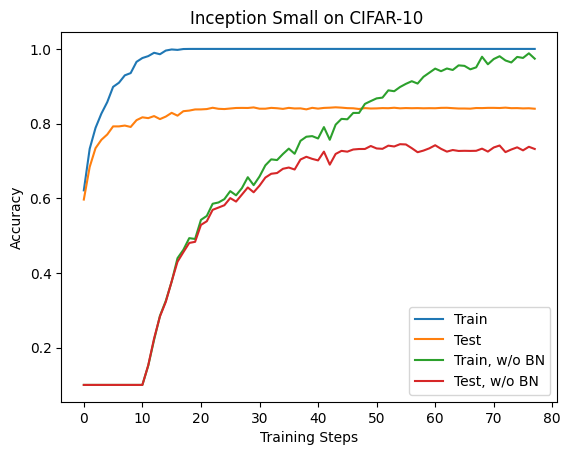

In [10]:
plt.plot(list(train_accuracy1),label='Train')
plt.plot(list(test_accuracy1),label='Test')
plt.plot(list(train_accuracy2),label='Train, w/o BN')
plt.plot(list(test_accuracy2),label='Test, w/o BN')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on CIFAR-10 ')
plt.legend()
plt.show()